<a href="https://colab.research.google.com/github/karma-os/Kaggle_study/blob/main/Feature_Engg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Feature Engg Notebook - Spooky author

>**Points to learn**
- _Use of Meta Features( num of words(unique, stop)_
- _Feature importance_
- _XGB parameters and methods_


>**Some issues**
- This notebook needs `preprocessing`(especially, fill nan)
- o.w. it will produce some errors ;-(
- `pd.iterrows` 등의 loop 문.
- 전반적으로 SVD 많이 쓰더라.



In [1]:
import os
need= "drive/MyDrive/Kaggle_kernel/data/spooky"

if os.getcwd() == "/content":
    chdir = os.path.join(os.getcwd(),need)
    os.chdir(need)

In [2]:
#Linux switch command : 
"""
-f  freshen existing files, create none
-n  never overwrite existing files         
-q  quiet mode (-qq => quieter)
-o  overwrite files WITHOUT prompting 
"""

!unzip -n train.zip 
!unzip -n test.zip
!unzip -n sample_submission.zip

Archive:  train.zip
Archive:  test.zip
Archive:  sample_submission.zip


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import xgboost as xgb
import string


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

color = sns.color_palette()

%matplotlib inline





In [4]:
#For NLTK
nltk.download("punkt")
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print("train_df shape:",train_df.shape)
print("test_df shape:", test_df.shape)


train_df shape: (19579, 3)
test_df shape: (8392, 2)


In [6]:
train_df.head(3)

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


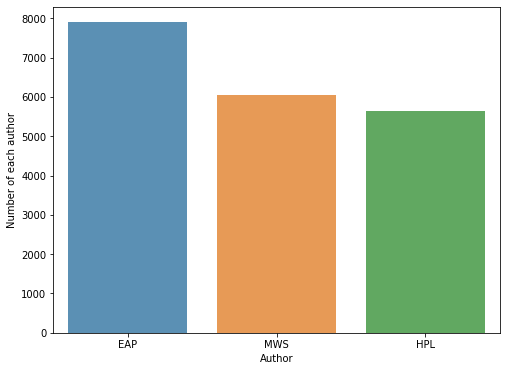

In [7]:
cnt_srs = train_df["author"].value_counts()

plt.figure(figsize = (8,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha = 0.8)
plt.xlabel("Author")
plt.ylabel("Number of each author")

import warnings
warnings.filterwarnings("ignore")

# Pandas 반복문 : array.iterrows

- dataframe row를 (index, row)로 반복함.
- 반복하는 것을 편집하는 건 무의미함.

## Similar metohd
**pd.itertuples**
- dataframe을 namedtuple로 반복.

**pd.iteritems**
- dataframe을 (column, series)로 반복함.

In [8]:
grouped_df = train_df.groupby(by = "author")
for name, group in grouped_df:
    print("Author name:", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt+=1
        print("\n")
        if cnt==5: break
    print()

Author name: EAP
This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.


In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.


The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.


The surcingle hung in ribands from my body.


I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt that yo

## Feature Engineering

### Type 1 : Meta Features
- features extracted from text like num of words, num of stopwords.

### Type 2: Text-based features
- features directly based on the text/words(e.g. freq, svd, word2vec)

##<font color ="blue">**Meta Features**</font>

In [9]:
from nltk.corpus import stopwords

In [10]:
eng_stopwords = set(stopwords.words('english'))
pd.options.mode.chained_assignment = None


"""
String 라이브러리에서 일반적으로 string.punctuation 등의 기능 지원.
"""


'\nString 라이브러리에서 일반적으로 string.punctuation 등의 기능 지원.\n'

In [11]:
## Num of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Num of words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x:len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x:len(set(str(x).split())))

## Num of characters in the text : 아마 공백도 포함인듯 ## 
train_df["num_chars"] = train_df["text"].apply(lambda x:len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x:len(str(x)))

## Num of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w in eng_stopwords]))

## Num of punctations in the text ##
train_df["num_punctuations"] = train_df["text"].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))
test_df["num_punctuations"] = test_df["text"].apply(lambda x: len([w for w in str(x) if w in string.punctuation]))

## Num of upper case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))

## Num of title case in the text##
"""
TItle case란, Hello, World! 처럼 각 단어가 대문자로 시작하고 그 외엔 다 소문자여야해!
"""
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Avg length of the words in the text ##

train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))




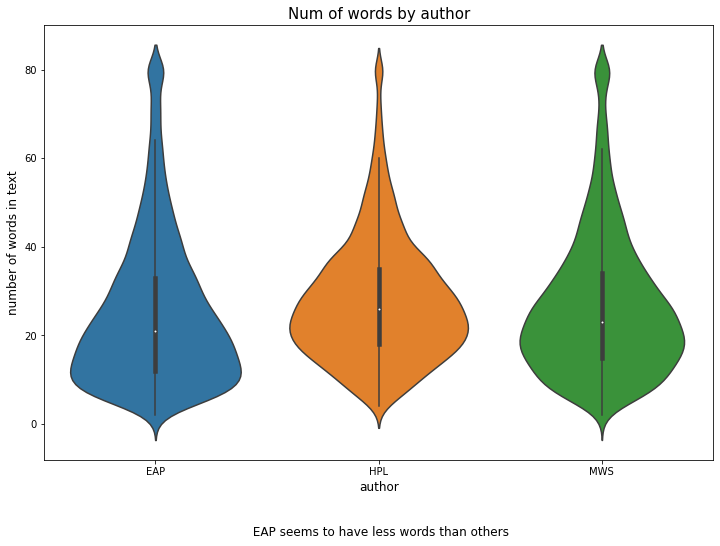

In [12]:
#Trunctation for better visuals
train_df["num_words"].loc[train_df["num_words"]>80] = 80

plt.figure(figsize = (12,8))
sns.violinplot(x = 'author', y = "num_words", data = train_df)
plt.xlabel("author\n\n\n EAP seems to have less words than others", fontsize = 12)
plt.ylabel("number of words in text", fontsize = 12)
plt.title("Num of words by author", fontsize = 15)
plt.show()



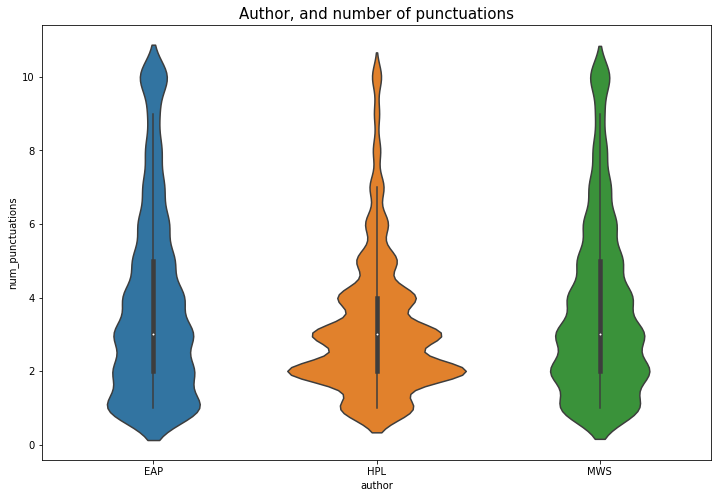

In [13]:
train_df["num_punctuations"].loc[train_df["num_punctuations"]>10] = 10
plt.figure(figsize = (12,8))
sns.violinplot(x = "author", y = "num_punctuations", data = train_df)
plt.xlabel("author")
plt.title("Author, and number of punctuations", fontsize = 15)
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder

In [15]:
##Prepare the data for modeling
author_mapping_dict = {"EAP":0,"HPL":1,"MWS":2}
train_y = train_df["author"].map(author_mapping_dict)

train_id = train_df["id"].values
test_id  = test_df["id"].values

##Recompute Truncated variables again

train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ["id","text"]

train_X = train_df.drop(cols_to_drop+["author"], axis = 1)
test_X  = test_df.drop(cols_to_drop, axis = 1) 



## XGBOOST

- eta: GBM의 lr
- num_boost_around = weak learner의 수
- colsample_bytree = 트리 생성에 필요한 피쳐의 샘플링


**DMatrix** : numpy 인자를 받아서 만들어지는 XGB 만의 전용 데이터셋



In [16]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 3
    param['silent'] = 1
    param['num_class'] = 3
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    ## To handle column mismatch
    test_X = test_X[train_X.columns]

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        test_X2 = test_X2[train_X.columns]
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

위 코드는 XGB로 dev, val, test를 쪼개기 위한 것임은 알겠음.

아래 코드 이해해보자!

- pred_full-test 는 왜있는걸까? 

In [17]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))

print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.09366	test-mlogloss:1.09442
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.04156	test-mlogloss:1.05178
[40]	train-mlogloss:1.0235	test-mlogloss:1.03957
[60]	train-mlogloss:1.0104	test-mlogloss:1.03011
[80]	train-mlogloss:1.00015	test-mlogloss:1.02283
[100]	train-mlogloss:0.992085	test-mlogloss:1.01733
[120]	train-mlogloss:0.984127	test-mlogloss:1.01211
[140]	train-mlogloss:0.97751	test-mlogloss:1.00827
[160]	train-mlogloss:0.97241	test-mlogloss:1.005
[180]	train-mlogloss:0.967188	test-mlogloss:1.00186
[200]	train-mlogloss:0.962802	test-mlogloss:1.00044
[220]	train-mlogloss:0.958951	test-mlogloss:0.999086
[240]	train-mlogloss:0.955047	test-mlogloss:0.997492
[260]	train-mlogloss:0.951796	test-mlogloss:0.996408
[280]	train-mlogloss:0.948619	test-mlogloss:0.995062
[300]	train-mlogloss:0.945647	test-mlogloss:0.994417
[320]	train-mlogloss:0.942782

## Meta features 만으로 0.987!

Exception ignored in: <function Booster.__del__ at 0x7f7d4b71fb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'
Exception ignored in: <function Booster.__del__ at 0x7f7d4b71fb90>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


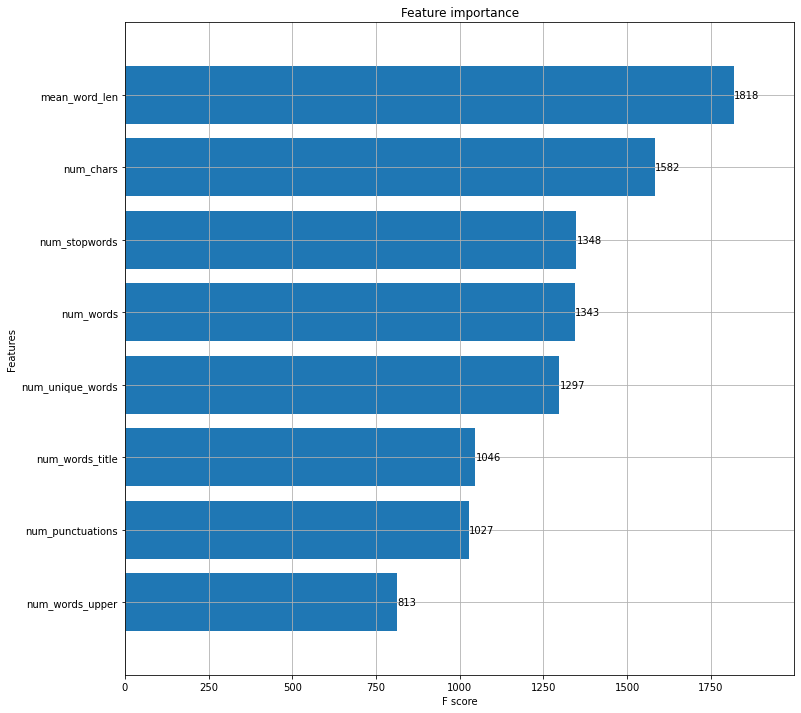

In [ ]:
fig, ax = plt.subplots(figsize = (12,12))
xgb.plot_importance(model, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

# 전체 dataset으로 학습하고, train과 test는 transform만!

In [18]:
#Fit_transform the tfidf vectorizer

tfidf_vec = TfidfVectorizer(stop_words = "english", ngram_range = (1,3))
full_tfidf = tfidf_vec.fit_transform(train_df["text"].values.tolist()+test_df["text"].values.tolist())
train_tfidf = tfidf_vec.transform(train_df["text"].values.tolist())
test_tfidf  = tfidf_vec.transform(train_df["text"].values.tolist())

Now we have some options.(Because sparse data)

_1. Choose top n features from tfidf, and convert it into dense format, concat with others._

_2. Build model using these sparse features, and use predictions along with other dense features_

In [19]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

**NB on Word TFIDF Vec**

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  0.8422161983612855


# 시각화 코드 공부

In [22]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  #아마 나누는 수를 matrix 전반에 적용시켜야 하니까 이랬나봐!
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

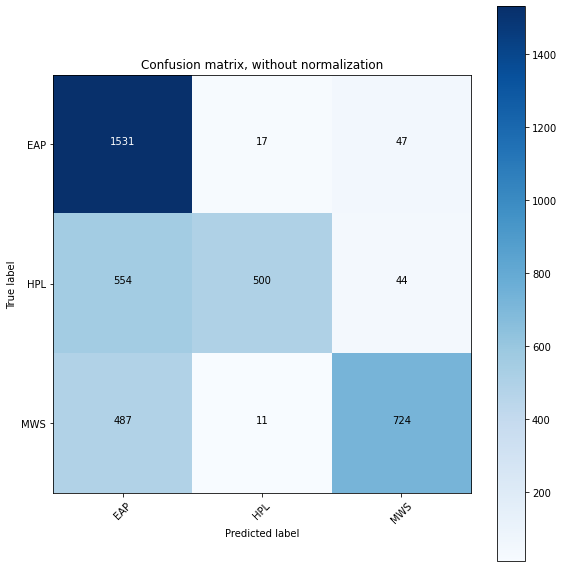

In [23]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['EAP', 'HPL', 'MWS'],
                      title='Confusion matrix, without normalization')
plt.show()

**SVD on word TFIDF**
Generally works well!

In [24]:
n_comp = 20
svd_obj = TruncatedSVD(n_components = n_comp, algorithm = "arpack")
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word+'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word+'+str(i) for i in range(n_comp)]

train_df = pd.concat([train_df, train_svd],axis = 1)
test_df  = pd.concat([test_df, test_svd], axis = 1)

del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd


In [42]:
train_df["text"] = train_df["text"].replace(np.nan," ")
test_df["text"]  = test_df["text"].replace(np.nan," ")

In [27]:
##FIt-trnasform the Word CVec
"""
코드 그대로 실행시키면 오류가 나는데, 아마 NaN때문인듯. iterable은 str, unicode 를 반환해야함.
"""


tfidf_vec = CountVectorizer(stop_words = 'english', ngram_range = (1,3))
tfidf_vec.fit(train_df["text"].astype("U").values.tolist() + test_df["text"].astype("U").values)
train_tfidf = tfidf_vec.transform(train_df["text"].astype("U").values.tolist())
test_tfidf  = tfidf_vec.transform(test_df["text"].astype("U").values.tolist())


In [29]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_eap"] = pred_train[:,0]
train_df["nb_cvec_hpl"] = pred_train[:,1]
train_df["nb_cvec_mws"] = pred_train[:,2]
test_df["nb_cvec_eap"] = pred_full_test[:,0]
test_df["nb_cvec_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_mws"] = pred_full_test[:,2]

Mean cv score :  0.45077574192280545


In [ ]:
test_df["text"]

0        Still, as I urged our leaving Ireland with suc...
1        If a fire wanted fanning, it could readily be ...
2        And when they had broken down the frail door t...
3        While I was thinking how I should possibly man...
4        I am not sure to what limit his knowledge may ...
                               ...                        
19574                                                  NaN
19575                                                  NaN
19576                                                  NaN
19577                                                  NaN
19578                                                  NaN
Name: text, Length: 19579, dtype: object

# Counting special characters

* Use Count vectorizer at a character level to get some features.



In [32]:
##Fit-transform the tfidf vec

tfidf_vec = CountVectorizer(ngram_range = (1,7), analyzer = "char")
tfidf_vec.fit(train_df["text"].astype("U").values.tolist() + test_df["text"].astype("U").values.tolist())
train_tfidf = tfidf_vec.transform(train_df["text"].astype("U").values.tolist())
test_tfidf  = tfidf_vec.transform(test_df["text"].astype("U").values.tolist())


cv_scores = []

pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_eap"] = pred_train[:,0]
train_df["nb_cvec_char_hpl"] = pred_train[:,1]
train_df["nb_cvec_char_mws"] = pred_train[:,2]
test_df["nb_cvec_char_eap"] = pred_full_test[:,0]
test_df["nb_cvec_char_hpl"] = pred_full_test[:,1]
test_df["nb_cvec_char_mws"] = pred_full_test[:,2]





Mean cv score :  3.768405608254846


In [45]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_eap"] = pred_train[:,0]
train_df["nb_tfidf_char_hpl"] = pred_train[:,1]
train_df["nb_tfidf_char_mws"] = pred_train[:,2]
test_df["nb_tfidf_char_eap"] = pred_full_test[:,0]
test_df["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test_df["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.8201562702755


# SVD on Character TFIDF

In [37]:
full_tfidf

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 5), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [44]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))
    
train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [48]:
cols_to_drop = ['id', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.00271	test-mlogloss:1.00283
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.411729	test-mlogloss:0.417288
[40]	train-mlogloss:0.341521	test-mlogloss:0.355829
[60]	train-mlogloss:0.319627	test-mlogloss:0.340716
[80]	train-mlogloss:0.30388	test-mlogloss:0.331942
[100]	train-mlogloss:0.292765	test-mlogloss:0.326773
[120]	train-mlogloss:0.283543	test-mlogloss:0.322403
[140]	train-mlogloss:0.275627	test-mlogloss:0.319776
[160]	train-mlogloss:0.26702	test-mlogloss:0.31683
[180]	train-mlogloss:0.259872	test-mlogloss:0.314695
[200]	train-mlogloss:0.253401	test-mlogloss:0.312948
[220]	train-mlogloss:0.247237	test-mlogloss:0.311975
[240]	train-mlogloss:0.241406	test-mlogloss:0.31128
[260]	train-mlogloss:0.235436	test-mlogloss:0.310494
[280]	train-mlogloss:0.230287	test-mlogloss:0.30945
[300]	train-mlogloss:0.225125	test-mlogloss:0.30883
[320]	train-mlo

ValueError: ignored